In [9]:
!pip install tensorflow opencv-python-headless matplotlib psutil GPUtil ffmpeg-python

In [10]:
import tensorflow as tf

**Loading Dataset from Tensorflow**

In [11]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Reshape and normalize the data
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)


**Training a GPU based OCR model**

In [12]:
def create_ocr_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_ocr_model()
model.fit(train_images, train_labels, epochs=2, batch_size=32, validation_data=(test_images, test_labels))


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9127 - loss: 0.2868 - val_accuracy: 0.9861 - val_loss: 0.0403
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - accuracy: 0.9872 - loss: 0.0425 - val_accuracy: 0.9903 - val_loss: 0.0296


In [23]:

import time

# Evaluate on GPU
start_time = time.time()
_, gpu_accuracy = model.evaluate(test_images, test_labels, verbose=0)
gpu_time = time.time() - start_time
print("GPU Accuracy: {:.2f}%".format(gpu_accuracy * 100))
print("GPU Time: {:.4f} seconds".format(gpu_time))

# Force CPU usage
with tf.device('/CPU:0'):
  cpu_model = create_ocr_model()
  cpu_model.fit(train_images, train_labels, epochs=2, batch_size=32, validation_data=(test_images, test_labels), verbose=0)

  start_time = time.time()
  _, cpu_accuracy = cpu_model.evaluate(test_images, test_labels, verbose=0)
  cpu_time = time.time() - start_time
  print("CPU Accuracy: {:.2f}%".format(cpu_accuracy * 100))
  print("CPU Time: {:.4f} seconds".format(cpu_time))

# Compare performance
print("\nPerformance Comparison:")
print("GPU is {:.2f} times faster than CPU".format(cpu_time / gpu_time))


GPU Accuracy: 99.03%
GPU Time: 2.6506 seconds


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CPU Accuracy: 98.88%
CPU Time: 2.6278 seconds

Performance Comparison:
GPU is 0.99 times faster than CPU


In [13]:
model.save('ocr_model.h5')

**Converting GPU based model to CPU **

In [14]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('ocr_model_cpu.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpreemhr5g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_32')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136914404932800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914404919600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914404917312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914403778176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914403777648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914403782928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914403778000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136914403775888: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [15]:
interpreter = tf.lite.Interpreter(model_path='ocr_model_cpu.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [16]:

input_shape_tflite = input_details[0]['shape'][1:3]


**Proceesing video input with both CPU and GPU**

In [17]:
import time
import cv2
import numpy as np
import psutil
import GPUtil

def process_video_with_model(video_path, output_path, model, use_gpu=False, is_tflite=False):
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    total_time = 0
    accuracies = []
    frame_times = []
    cpu_usages = []
    gpu_usages = []

    # Determine input shape based on the model
    if is_tflite:
        input_shape = input_details[0]['shape'][1:3]
    else:
        input_shape = model.input_shape[1:3]

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (input_shape[1], input_shape[0]))
        input_data = np.expand_dims(resized, axis=[0, -1]) / 255.0

        start_time = time.perf_counter()  # Start high-precision timing
        if is_tflite:
            interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
            interpreter.invoke()
            predictions = interpreter.get_tensor(output_details[0]['index'])
        else:
            with tf.device('/GPU:0' if use_gpu else '/CPU:0'):
                predictions = model.predict(input_data)
        end_time = time.perf_counter()  # End high-precision timing

        processing_time = end_time - start_time
        total_time += processing_time
        frame_times.append(processing_time)

        predicted_char = chr(np.argmax(predictions[0]) + 65)
        accuracy = np.max(predictions)
        accuracies.append(accuracy)

        cpu_usage = psutil.cpu_percent(interval=None)
        gpu_usage = None
        if use_gpu:
            gpus = GPUtil.getGPUs()
            gpu_usage = gpus[0].load * 100 if gpus else 0

        cpu_usages.append(cpu_usage)
        gpu_usages.append(gpu_usage if use_gpu else 0)

        fontScale = 1.5
        thickness = 3
        cv2.putText(frame, f"Predicted: {predicted_char}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Processing Time: {processing_time:.4f}s", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"Accuracy: {accuracy:.4f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        cv2.putText(frame, f"CPU Usage: {cpu_usage:.2f}%", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)
        if use_gpu:
            cv2.putText(frame, f"GPU Usage: {gpu_usage:.2f}%", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, fontScale, (0, 255, 0), thickness)

        out.write(frame)
        frame_count += 1

    average_fps = frame_count / total_time
    print(f"Average FPS ({'GPU' if use_gpu else 'CPU'}): {average_fps:.2f}")

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return average_fps, accuracies, frame_times, cpu_usages, gpu_usages


In [19]:
video_path = '/content/video.33.06_bc9a6d84.mp4'
output_path_gpu = 'output_video_gpu.avi'
output_path_cpu = 'output_video_cpu.avi'

# Process using the GPU model
fps_gpu, accuracies_gpu, frame_times_gpu, cpu_usages_gpu, gpu_usages = process_video_with_model(
    video_path, output_path_gpu, model, use_gpu=True)

# Process using the CPU model (TensorFlow Lite)
fps_cpu, accuracies_cpu, frame_times_cpu, cpu_usages_cpu, _ = process_video_with_model(
    video_path, output_path_cpu, interpreter, is_tflite=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

**Evaluating the performance of CPU and GPU**

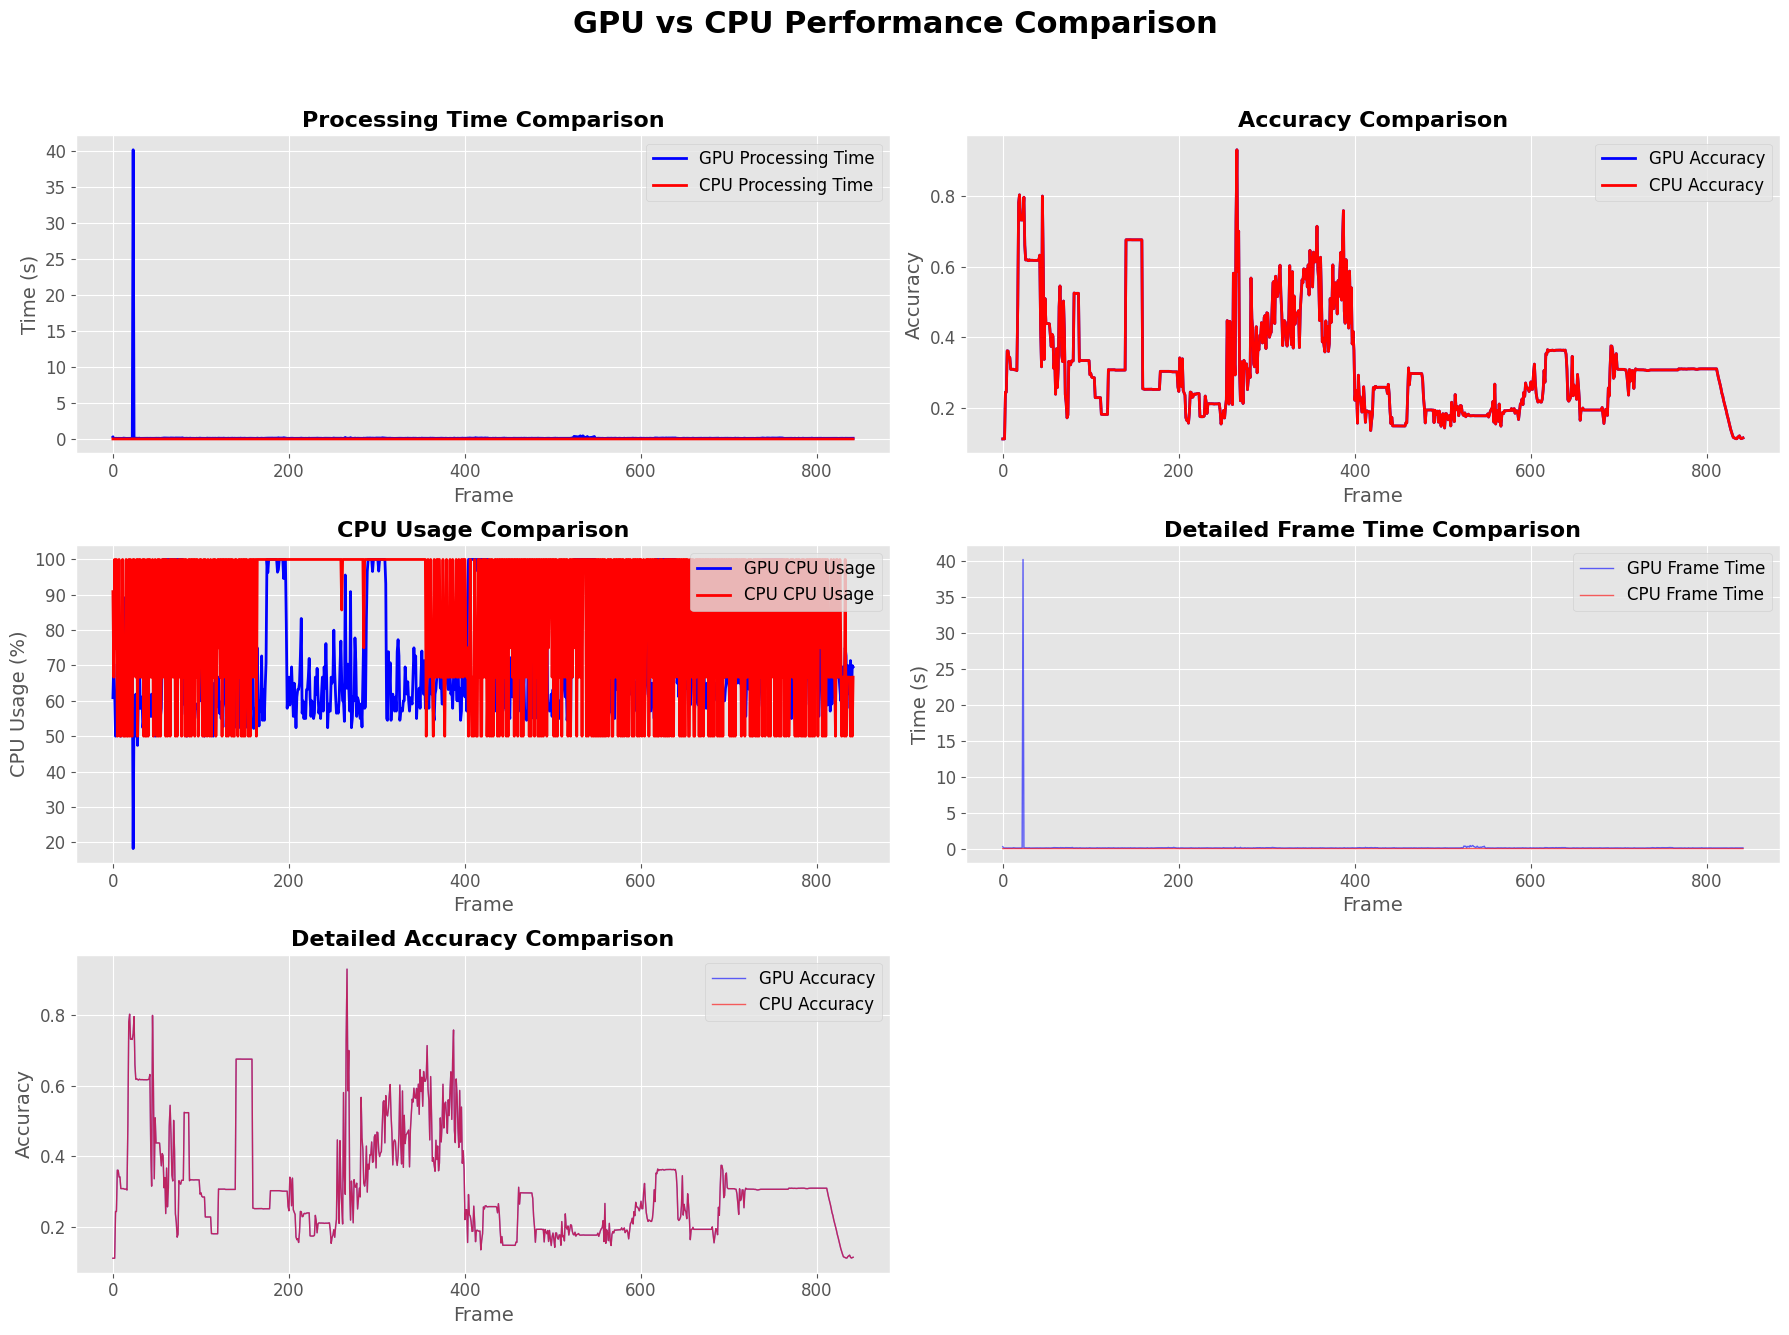

In [20]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('GPU vs CPU Performance Comparison', fontsize=22, fontweight='bold')


axes[0, 0].plot(frame_times_gpu, label='GPU Processing Time', color='blue', linewidth=2)
axes[0, 0].plot(frame_times_cpu, label='CPU Processing Time', color='red', linewidth=2)
axes[0, 0].set_title('Processing Time Comparison', fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Frame', fontsize=14)
axes[0, 0].set_ylabel('Time (s)', fontsize=14)
axes[0, 0].legend(loc='upper right', fontsize=12)
axes[0, 0].tick_params(axis='both', which='major', labelsize=12)

axes[0, 1].plot(accuracies_gpu, label='GPU Accuracy', color='blue', linewidth=2)
axes[0, 1].plot(accuracies_cpu, label='CPU Accuracy', color='red', linewidth=2)
axes[0, 1].set_title('Accuracy Comparison', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Frame', fontsize=14)
axes[0, 1].set_ylabel('Accuracy', fontsize=14)
axes[0, 1].legend(loc='upper right', fontsize=12)
axes[0, 1].tick_params(axis='both', which='major', labelsize=12)

axes[1, 0].plot(cpu_usages_gpu, label='GPU CPU Usage', color='blue', linewidth=2)
axes[1, 0].plot(cpu_usages_cpu, label='CPU CPU Usage', color='red', linewidth=2)
axes[1, 0].set_title('CPU Usage Comparison', fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel('Frame', fontsize=14)
axes[1, 0].set_ylabel('CPU Usage (%)', fontsize=14)
axes[1, 0].legend(loc='upper right', fontsize=12)
axes[1, 0].tick_params(axis='both', which='major', labelsize=12)

# Detailed Frame Time Comparison
axes[1, 1].plot(frame_times_gpu, label='GPU Frame Time', color='blue', alpha=0.6, linewidth=1)
axes[1, 1].plot(frame_times_cpu, label='CPU Frame Time', color='red', alpha=0.6, linewidth=1)
axes[1, 1].set_title('Detailed Frame Time Comparison', fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel('Frame', fontsize=14)
axes[1, 1].set_ylabel('Time (s)', fontsize=14)
axes[1, 1].legend(loc='upper right', fontsize=12)
axes[1, 1].tick_params(axis='both', which='major', labelsize=12)

axes[2, 0].plot(accuracies_gpu, label='GPU Accuracy', color='blue', alpha=0.6, linewidth=1)
axes[2, 0].plot(accuracies_cpu, label='CPU Accuracy', color='red', alpha=0.6, linewidth=1)
axes[2, 0].set_title('Detailed Accuracy Comparison', fontsize=16, fontweight='bold')
axes[2, 0].set_xlabel('Frame', fontsize=14)
axes[2, 0].set_ylabel('Accuracy', fontsize=14)
axes[2, 0].legend(loc='upper right', fontsize=12)
axes[2, 0].tick_params(axis='both', which='major', labelsize=12)

fig.delaxes(axes[2, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


**Analysis**

In [22]:
print("Performance Evaluation:")
print(f"FPS (GPU): {fps_gpu:.2f}")
print(f"FPS (CPU): {fps_cpu:.2f}")
print(f"Average CPU Usage (GPU mode): {np.mean(cpu_usages_gpu):.2f}%")
print(f"Average CPU Usage (CPU mode): {np.mean(cpu_usages_cpu):.2f}%")

Performance Evaluation:
FPS (GPU): 6.71
FPS (CPU): 2737.65
Average CPU Usage (GPU mode): 70.77%
Average CPU Usage (CPU mode): 82.57%
